In [22]:
import sys
from pathlib import Path
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Add Project Root to Path

In [23]:
project_root = Path(os.getcwd()).parent
sys.path.append(str(project_root))

### Imports

In [24]:
from src.modeling.mcmc import (
    load_data,
    prepare_data,
    build_model,
    sample_model,
    predict_match
)
from src.modeling.model_evaluation import (
    split_data_by_date,
    evaluate_model,
    print_metrics
)

### Load and Prepare Data

In [25]:
# Load all data
df = load_data()

# Split into training and testing
split_date = '2024-11-06'  # Adjust this date as needed
train_df, test_df = split_data_by_date(df, split_date)

# Prepare training data and build model
train_data = prepare_data(train_df)
model = build_model(train_data)
trace = sample_model(model)

Loaded 220 rows from match_logs


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [home_advantage, attack, defense, beta_home_xG, beta_away_xG, beta_home_possession, beta_away_possession, recent_form_coefficient]


Output()

Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


### Evaluate Model

In [26]:
metrics, predictions, actuals = evaluate_model(
    model_data=train_data,
    test_data=test_df,
    trace=trace,
    predict_match_fn=predict_match
)

print_metrics(metrics)


Model Evaluation Metrics:
Prediction Accuracy: 0.600

Brier Scores (lower is better):
Home Win: 0.314
Draw: 0.182
Away Win: 0.207

Mean Absolute Error in Goals:
Home Goals: 1.369
Away Goals: 0.832


### Analyze Specific Predictions

In [27]:
# Combine test_df and predictions
results_df = test_df.copy()  # Create a copy of test_df to avoid modifying the original

# Add predictions to the results DataFrame
results_df['home_win_prob'] = predictions['home_win_prob'].values
results_df['draw_prob'] = predictions['draw_prob'].values
results_df['away_win_prob'] = predictions['away_win_prob'].values
results_df['expected_home_goals'] = predictions['expected_home_goals'].values
results_df['expected_away_goals'] = predictions['expected_away_goals'].values

# Create matchup column
results_df['matchup'] = results_df['team'] + ' vs. ' + results_df['opponent']

# Format the result as score (goals_for - goals_against)
results_df['actual_score'] = results_df['goals_for'].astype(str) + '-' + results_df['goals_against'].astype(str)

# Select relevant columns to display
results_df = results_df[['date', 'matchup', 'actual_score', 'home_win_prob', 'draw_prob', 'away_win_prob', 'expected_home_goals', 'expected_away_goals']]

# Display the combined results
print(results_df.head(10).to_string(index=False))

      date                                      matchup actual_score  home_win_prob  draw_prob  away_win_prob  expected_home_goals  expected_away_goals
2024-11-09                    Liverpool vs. Aston-Villa          2-0        0.76175    0.15225        0.08600             2.598638             0.666780
2024-11-10                          Chelsea vs. Arsenal          1-1        0.68375    0.16475        0.15150             2.666474             1.016669
2024-11-10       Nottingham-Forest vs. Newcastle-United          1-3        0.34025    0.36100        0.29875             0.818560             0.736579
2024-11-09 Brighton-and-Hove-Albion vs. Manchester-City          2-1        0.50325    0.23825        0.25850             1.692211             1.104389
2024-11-10           Tottenham-Hotspur vs. Ipswich-Town          1-2        0.91325    0.05675        0.03000             4.696166             0.638726
2024-11-09                    Brentford vs. Bournemouth          3-2        0.40625    0

### Plot Actual vs. Predicted Goals

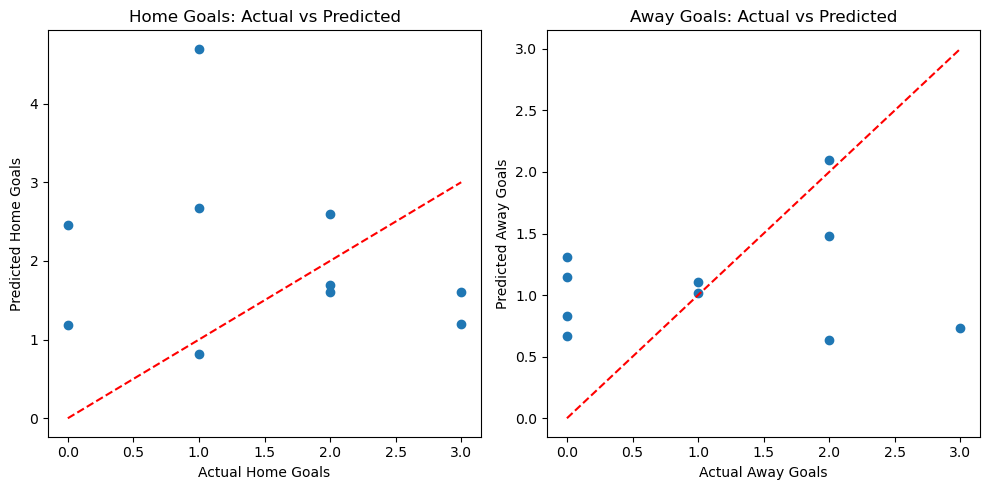

In [28]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(actuals['home_goals'], predictions['expected_home_goals'])
plt.plot([0, max(actuals['home_goals'])], [0, max(actuals['home_goals'])], 'r--')
plt.xlabel('Actual Home Goals')
plt.ylabel('Predicted Home Goals')
plt.title('Home Goals: Actual vs Predicted')

plt.subplot(1, 2, 2)
plt.scatter(actuals['away_goals'], predictions['expected_away_goals'])
plt.plot([0, max(actuals['away_goals'])], [0, max(actuals['away_goals'])], 'r--')
plt.xlabel('Actual Away Goals')
plt.ylabel('Predicted Away Goals')
plt.title('Away Goals: Actual vs Predicted')

plt.tight_layout()
plt.show()